In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import scipy.integrate

import subprocess

# Collimator Effectiveness

In [2]:
dataDir = '../../geant/data/sourceshielding1/'
dataFileBase = 'output'

nParticles = 100000

In [3]:
# Calculate surface fluxes
lead = 2
while lead <= 10:
    poly = 2
    while poly <= 10:
        
        file = dataDir + dataFileBase + '_' + str(lead) + '_' + str(poly) + '_' + str(nParticles) + '.root'
        
        # This is a hilariously slow way to do this tbh, but this is how to suppress error messages
        # For some reason although this notebook is running under root environment, CLING seems to
        # not be able to find libraries/header files. Activating the conda env for every single call
        # is stupidly slow but it works with relatively negligible overhead, so... - Lars
        #subprocess.run('. $CONDA_PREFIX/etc/profile.d/conda.sh; conda activate cern_root; ../build/DetectorSurfaceCounts ' + file, shell=True)
        subprocess.run('../build/DetectorSurfaceFlux ' + file, shell=True)
        
        poly += 2
    lead += 2

In [4]:
# Extract data from post analysis root file now

lead = 2
poly = 2

file = dataDir + dataFileBase + '_' + str(lead) + '_' + str(poly) + '_' + str(nParticles) + '_flux.root'
file = uproot.open(file)

data = file['Entering Flux']['neutron']['posz'].arrays(library='np')

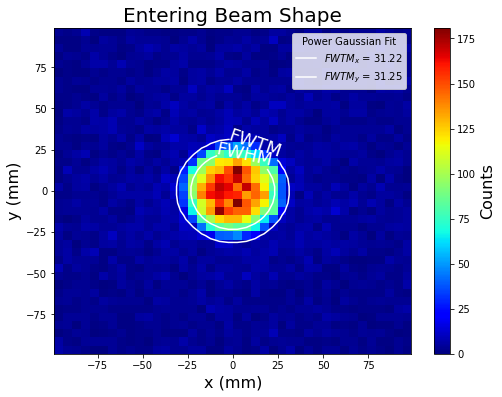

Roughly 75.6% of beam counts are in FWHM
Roughly 97.2% of beam counts are in FWTM


In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

(z, x, y, img) = ax.hist2d(data['coord1'], data['coord2'], bins=40, cmap=plt.cm.jet)

# Average the left and right values for each hist bin
x = np.convolve(x, np.ones(2)/2, mode='valid')
y = np.convolve(y, np.ones(2)/2, mode='valid')

# Fit the histogram using Gaussian

# Don't use this function except in this cell really, it is terrible
def GaussFit2DArr(r, amplitude, sigma_x, sigma_y, mu_x, mu_y, offset, power):
    x = r - np.array([[mu_x], [mu_y]])
    
    # inverse of covariance matrix
    sigma = [[1 / (sigma_x ** 2), 0], [0, 1 / (sigma_y ** 2)]]
    
    return offset + amplitude * np.exp(- (np.transpose(x, (0, 2, 1)) @ (sigma @ x)).ravel() ** power)

r = np.array(np.meshgrid(x, y)).T.reshape((-1, 2, 1))

bounds = ([0, 0, 0, -np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
popt, pcov = scipy.optimize.curve_fit(GaussFit2DArr, r, z.ravel(), p0=(500, 20, 20, 0, 0, z[0, 0], 1), bounds=bounds)

fit = GaussFit2DArr(r, *popt).reshape(x.shape[0], -1)

CS = ax.contour(x, y, fit, levels=[popt[0] / 10 + popt[5], popt[0] / 2 + popt[5]],colors='w')

ax.clabel(CS, CS.levels, inline=True, fmt={CS.levels[0] : "FWTM", CS.levels[1] : "FWHM"}, fontsize=18)

cbar = fig.colorbar(img, ax=ax)
cbar.ax.set_ylabel('Counts', fontsize=16)

ax.set_xlabel('x (mm)', fontsize=16)
ax.set_ylabel('y (mm)', fontsize=16)
ax.set_title('Entering Beam Shape', fontsize=20)

fwhmWidthX = (np.max(CS.allsegs[1][0][:,0]) - np.min(CS.allsegs[1][0][:,0])) / 2
fwtmWidthX = (np.max(CS.allsegs[0][0][:,0]) - np.min(CS.allsegs[0][0][:,0])) / 2
fwhmWidthY = (np.max(CS.allsegs[1][0][:,1]) - np.min(CS.allsegs[1][0][:,1])) / 2
fwtmWidthY = (np.max(CS.allsegs[0][0][:,1]) - np.min(CS.allsegs[0][0][:,1])) / 2

# Dummy plot to add a legend label
ax.plot(0, 0, "-", c='w', label='$FWTM_x$ = %.2f' % (fwtmWidthX))
ax.plot(0, 0, "-", c='w', label='$FWTM_y$ = %.2f' % (fwtmWidthY))

ax.legend(title="Power Gaussian Fit")

plt.show()

# Calculate how much of "beam" is inside FWHM and FWTM
background = popt[5]
totalCounts = np.sum(z)
realTotalCounts = totalCounts - background * x.shape[0] ** 2
fwhmCounts = 0
fwtmCounts = 0

for pos, count in zip(np.array(np.meshgrid(x, y)).T.reshape((-1, 2)), z.ravel()):
    dist2 = (pos[0] - popt[3]) ** 2 / fwhmWidthX ** 2 + (pos[1] - popt[4]) ** 2 / fwhmWidthY ** 2
    if (dist2 < 1):
        fwhmCounts += (count - background)
        
    dist2 = (pos[0] - popt[3]) ** 2 / fwtmWidthX ** 2 + (pos[1] - popt[4]) ** 2 / fwtmWidthY ** 2
    if (dist2 < 1):
        fwtmCounts += (count - background)
        
fwhmPortion = fwhmCounts / realTotalCounts
fwtmPortion = fwtmCounts / realTotalCounts
print("Roughly %2.1f%% of beam counts are in FWHM" % (fwhmPortion * 100))
print("Roughly %2.1f%% of beam counts are in FWTM" % (fwtmPortion * 100))